In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import (
    accuracy_score, top_k_accuracy_score, f1_score, matthews_corrcoef,
    classification_report, precision_recall_fscore_support,
    confusion_matrix, ConfusionMatrixDisplay
)

2025-05-27 02:33:46.218081: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-27 02:33:51.224412: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-27 02:33:52.914972: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748313235.759855    2376 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748313236.450672    2376 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748313242.289446    2376 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git # get the data here
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [25]:
!cd pubmed-rct/

In [26]:
dataset_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [27]:
def get_raw_data(filepath):
    with open(filepath) as f:
        return f.readlines()

In [28]:
# Load the data
train_data = get_raw_data(dataset_dir + 'train.txt')

In [29]:
import os

In [30]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [32]:
# View the first 20 lines from the dataset text file
train_data[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [33]:
# %%
def preprocess_raw_data(filepath):
    raw_data = get_raw_data(filepath)
    abstract_data = ''
    abstract_samples = []
    abstract_id = 0

    for line in raw_data:
        if line.startswith('###'): # check if current line is an abstract start (line -> ###[abstract_id]\n)
            abstract_id = int(line.replace('###', '').replace('\n', '')) # get abstract id
            abstract_data = ''

        elif line.isspace(): # check if current line is an abstract end (line -> '\n')
            abstract_data_split = abstract_data.splitlines()

            for abstract_line_number, abstract_line in enumerate(abstract_data_split):
                line_data = {} # store lines in dictionary
                target_text_split = abstract_line.split("\t") # split target label from text

                line_data["abstract_id"] = abstract_id # get abstract id
                line_data["line_id"] = f'{abstract_id}_{abstract_line_number}_{len(abstract_data_split)}' # create id for each line
                line_data["abstract_text"] = target_text_split[1] # get target text and lower it
                line_data["line_number"] = abstract_line_number # get line number in the abstract
                line_data["total_lines"] = len(abstract_data_split) # get total count for abstract lines (counter starts at 1)
                line_data['current_line'] = f'{abstract_line_number}_{len(abstract_data_split)}' # embed line_number & total_lines into one feature
                line_data["target"] = target_text_split[0] # get target label

                abstract_samples.append(line_data) # append line data to abstract samples list

        else: # if the above conditions aren't fulfilled, the line is a abstract text line (line -> [TARGET]\t[abstract_text])
            abstract_data += line

    return abstract_samples
# %%

In [34]:
# Get train data from file and preprocess it
train_samples = preprocess_raw_data(dataset_dir + "train.txt")

In [35]:
# Get dev/validation data from file and preprocess it
val_samples = preprocess_raw_data(dataset_dir + "dev.txt")

In [36]:
# Get test data from file and preprocess it
test_samples = preprocess_raw_data(dataset_dir + "test.txt")

In [37]:
train_count = len(train_samples)
val_count = len(val_samples)
test_count = len(test_samples)
total = train_count + val_count + test_count

In [38]:
print(f'train samples count:\t\t{train_count}')
print(f'dev/validation samples count:\t{val_count}')
print(f'test samples count:\t\t{test_count}')

print(f'\ntotal samples:\t\t\t{total}')

train samples count:		180040
dev/validation samples count:	30212
test samples count:		30135

total samples:			240387


In [39]:
# View first 10 abstracts from the train set
train_samples[:10]

[{'abstract_id': 24293578,
  'line_id': '24293578_0_12',
  'abstract_text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'line_number': 0,
  'total_lines': 12,
  'current_line': '0_12',
  'target': 'OBJECTIVE'},
 {'abstract_id': 24293578,
  'line_id': '24293578_1_12',
  'abstract_text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 12,
  'current_line': '1_12',
  'target': 'METHODS'},
 {'abstract_id': 24293578,
  'line_id': '24293578_2_12',
  'abstract_text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 12,
  'cur

In [40]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [41]:
# View the first 20 samples in train_df
train_df.head(20)

,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target
0,24293578,24293578_0_12,To investigate the efficacy of @ weeks of dail...,0,12,0_12,OBJECTIVE
1,24293578,24293578_1_12,A total of @ patients with primary knee OA wer...,1,12,1_12,METHODS
2,24293578,24293578_2_12,Outcome measures included pain reduction and i...,2,12,2_12,METHODS
3,24293578,24293578_3_12,Pain was assessed using the visual analog pain...,3,12,3_12,METHODS
4,24293578,24293578_4_12,Secondary outcome measures included the Wester...,4,12,4_12,METHODS
5,24293578,24293578_5_12,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",5,12,5_12,METHODS
6,24293578,24293578_6_12,There was a clinically relevant reduction in t...,6,12,6_12,RESULTS
7,24293578,24293578_7_12,The mean difference between treatment arms ( @...,7,12,7_12,RESULTS
8,24293578,24293578_8_12,"Further , there was a clinically relevant redu...",8,12,8_12,RESULTS
9,24293578,24293578_9_12,These differences remained significant at @ we...,9,12,9_12,RESULTS


In [42]:
# Distribution of labels in training data
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

/tmp/ipykernel_2376/1548999433.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=train_distribution.values,
/tmp/ipykernel_2376/1548999433.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=val_distribution.values,
/tmp/ipykernel_2376/1548999433.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(


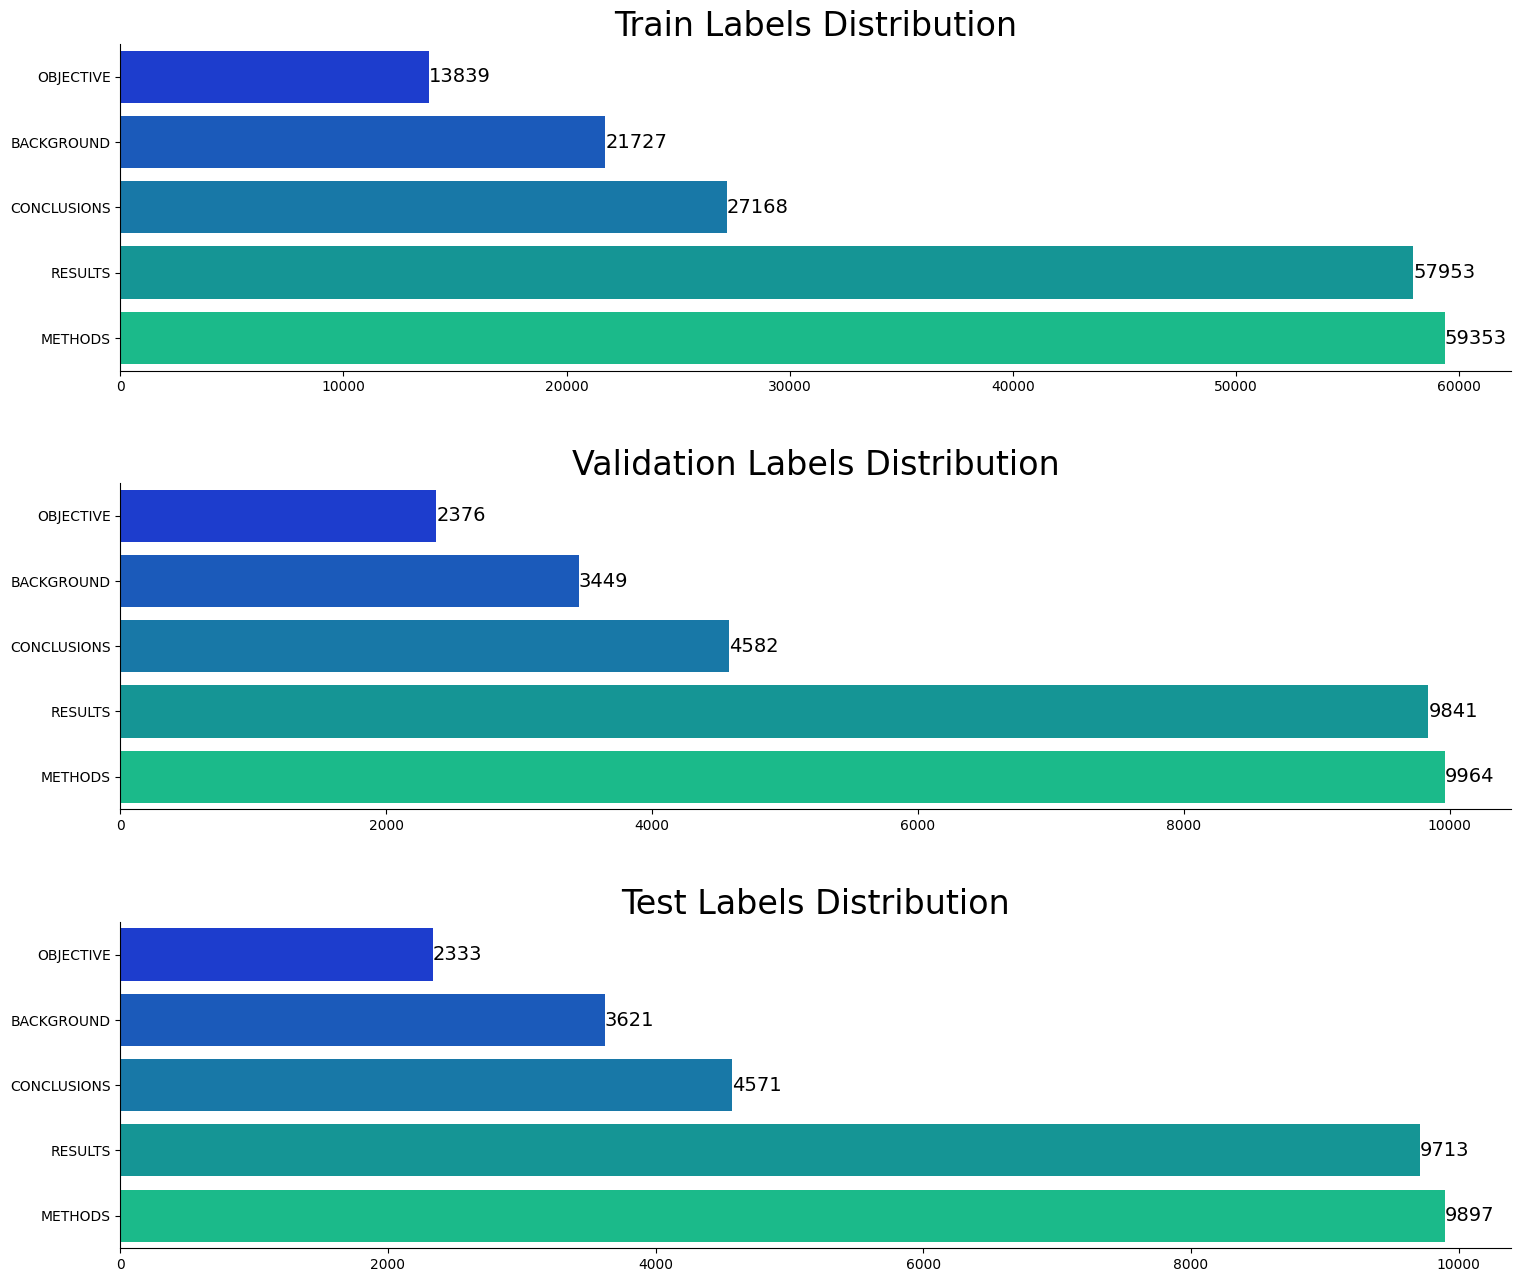

In [45]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16, 14))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)
sns.despine();

# Plot Train Labels Distribution
ax1.set_title('Train Labels Distribution', fontsize=24)
train_distribution = train_df['target'].value_counts().sort_values()
bar_plot = sns.barplot(x=train_distribution.values,
            y=list(train_distribution.keys()),
            orient="h", palette=sns.color_palette("winter", 5),
            ax=ax1);

for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.0f', fontsize=14);

# Plot Validation Labels Distribution
ax2.set_title('Validation Labels Distribution', fontsize=24)
val_distribution = val_df['target'].value_counts().sort_values()
bar_plot = sns.barplot(x=val_distribution.values,
            y=list(val_distribution.keys()),
            orient="h", palette=sns.color_palette("winter", 5),
            ax=ax2);
for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.0f', fontsize=14);

# Plot Test Labels Distribution
ax3.set_title('Test Labels Distribution', fontsize=24)
test_distribution = test_df['target'].value_counts().sort_values()
bar_plot = sns.barplot(
    x=test_distribution.values,
    y=list(test_distribution.keys()),
    orient="h", palette=sns.color_palette("winter", 5),
    ax=ax3);

for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.0f', fontsize=14);

In [46]:
# Convert abstract text lines into lists
train_sentences = train_df["abstract_text"].tolist()
val_sentences = val_df["abstract_text"].tolist()
test_sentences = test_df["abstract_text"].tolist()
# %%
train_sentences_count = len(train_sentences)
val_sentences_count = len(val_sentences)
test_sentences_count = len(test_sentences)
total_sentences_count = train_sentences_count + val_sentences_count + test_sentences_count

print(f'Train samples count:\t\t{train_sentences_count}')
print(f'Dev/Validation sample count:\t{val_sentences_count}')
print(f'Test sample count:\t\t{test_sentences_count}')
print(f'Total samples:\t\t\t{total_sentences_count}')

Train samples count:		180040
Dev/Validation sample count:	30212
Test sample count:		30135
Total samples:			240387


In [47]:
# View first 5 lines of train sentences
train_sentences[:5]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .']

In [48]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
# %%
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

In [49]:
train_df["target"][0]

'OBJECTIVE'

In [50]:
# inspect one hot encoded targets
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [51]:
label_encoder = LabelEncoder()
# %%
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

In [52]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [53]:
# Get class names and number of classes from label_encoder
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

print(f'Number of classes: {num_classes}')
print(f'Classes: {class_names}')

Number of classes: 5
Classes: ['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']


In [54]:
line_one_hot_encoder = OneHotEncoder(sparse_output=False)
# %%

train_lines_encoded = line_one_hot_encoder.fit_transform(train_df["current_line"].to_numpy().reshape(-1, 1)).astype(np.float32)
val_lines_encoded = line_one_hot_encoder.transform(val_df["current_line"].to_numpy().reshape(-1, 1)).astype(np.float32)
test_lines_encoded = line_one_hot_encoder.transform(test_df["current_line"].to_numpy().reshape(-1, 1)).astype(np.float32)
# %%
test_lines_encoded.shape

(30135, 460)

In [55]:
def apply_smoothing(line_one_hot, esp=0.01):
    return np.abs(line_one_hot - esp)

In [56]:
def revert_smoothing(line_one_hot_smooth, esp=0.01):
    unsmooth = line_one_hot_smooth

    unsmooth[unsmooth>esp] = 1.0
    unsmooth[unsmooth<=esp] = 0.0

    return unsmooth

In [57]:
# Only apply smoothing to train lines feature
train_lines_encoded = apply_smoothing(train_lines_encoded)

In [58]:
def create_pipeline(features, labels, batch_size=32, shuffle=False, cache=False, prefetch=False) -> tf.data.Dataset:
    '''
    Generates an input pipeline using the tf.data API for training and inference.

    @params
        - features: (tuple) -> tuple containing the feature data
        - labels: (tf.Tensor | np.ndarray, default=None) -> target data related to the feature data
        - batch_size: (int) -> size for batched (default=32)
        - shuffle: (bool) -> condition for data shuffling, data is shuffled when True (default=False)
        - cache: (bool) -> condition for caching data, data is cached in memory when True (default=False)
        - prefetch: (bool) -> condition for prefeching data, data is prefetched when True (default=False)

    @returns
        - dataset: (tf.data.Dataset) -> dataset input pipeline used to train a TensorFlow model
    '''

    AUTOTUNE = tf.data.AUTOTUNE

    # Create dataset with features and labels
    ds = tf.data.Dataset.from_tensor_slices((features, labels))

    # Apply shuffling based on condition
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)

    # Apply batching
    ds = ds.batch(batch_size)

    # Apply caching based on condition
    # Note: Do this if the data is small enough to fit in memory!!!
    if cache:
        ds = ds.cache(buffer_size=AUTOTUNE)

    # Apply prefetching based on condition
    # Note: This will result in memory trade-offs
    if prefetch:
        ds = ds.prefetch(buffer_size=AUTOTUNE)

    # Return the dataset
    return ds

In [59]:
BATCH_SIZE = 32

# Create preprocessed training dataset
train_features = (train_sentences, train_lines_encoded.astype(np.float32))
train_labels = train_labels_one_hot.astype(np.float32)

# Create preprocessed train input data pipeline
train_ds = create_pipeline(
    train_features, train_labels,
    batch_size=BATCH_SIZE, shuffle=True,
    cache=False, prefetch=True)
# %%
# Create preprocessed validation dataset
val_features = (val_sentences, val_lines_encoded.astype(np.float32))
val_labels = val_labels_one_hot.astype(np.float32)

# Create preprocessed validation input data pipeline
val_ds = create_pipeline(val_features, val_labels,
                         batch_size=BATCH_SIZE, shuffle=False,
                         cache=False, prefetch=True)
# %%
# Create preprocessed test dataset
test_features = (test_sentences, test_lines_encoded.astype(np.float32))
test_labels = test_labels_one_hot.astype(np.float32)

# Create preprocessed test input data pipeline
test_ds = create_pipeline(test_features, test_labels,
                          batch_size=BATCH_SIZE, shuffle=False,
                          cache=False, prefetch=True)

2025-05-27 03:01:47.708187: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-05-27 03:01:47.856194: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 331273600 exceeds 10% of free system memory.
2025-05-27 03:01:48.107307: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 55590080 exceeds 10% of free system memory.
2025-05-27 03:01:48.266080: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 55448400 exceeds 10% of free system memory.


In [60]:
# View string representation of datasets
print('========================================')
print('Train Input Data Pipeline:\n\n', train_ds)
print('========================================')
print('Validation Input Data Pipeline:\n\n', val_ds)
print('========================================')
print('Test Input Data Pipeline:\n\n', test_ds)
print('========================================')

Train Input Data Pipeline:

 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 460), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
Validation Input Data Pipeline:

 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 460), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
Test Input Data Pipeline:

 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 460), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>


In [61]:
# When using tensorflow_text, uncomment the line below to import the module
# import tensorflow_text as text

# Here's a function to get any model/preprocessor from tensorflow hub
def get_tfhub_model(model_link, model_name, model_trainable=False):
    return hub.KerasLayer(model_link,
                          trainable=model_trainable,
                          name=model_name)

In [62]:
# get Universal Sentence Encoder here
encoder_link = 'https://tfhub.dev/google/universal-sentence-encoder/4'
encoder_name = 'universal_sentence_encoder'
encoder_trainable=False # set trainable to False for inference-only

encoder = get_tfhub_model(encoder_link, encoder_name, model_trainable=encoder_trainable)

In [63]:
class SelfAttentionBlock(layers.Layer):

    def __init__(self, units: int, activation='gelu', kernel_initializer='GlorotNormal', **kwargs):
        super(SelfAttentionBlock, self).__init__(**kwargs)
        self.units = units
        self.activation = activation
        self.kernel_initializer = tf.keras.initializers.deserialize(kernel_initializer)

        self.query = layers.LSTM(self.units, activation=self.activation,
                                 kernel_initializer=self.kernel_initializer,
                                 return_sequences=True, name=f'block_query_lstm')

        self.value = layers.LSTM(self.units, activation=self.activation,
                                 kernel_initializer=self.kernel_initializer, go_backwards=True,
                                 return_sequences=True, name=f'block_value_lstm')

        self.attention = layers.AdditiveAttention(name='block_attention')
        self.average_pooler = layers.GlobalAveragePooling1D(name='block_average_pooler')
        self.query_batch_norm = layers.BatchNormalization(name='block_query_batch_norm')
        self.attention_batch_norm = layers.BatchNormalization(name='block_attention_batch_norm')
        self.residual = layers.Add(name='block_residual')


    def __call__(self, x):
        # Expand dimensions for LSTMs
        dim_expand_layer = layers.Lambda(lambda embedding: tf.expand_dims(embedding, axis=1), name='block_dim_expand')
        x_expanded = dim_expand_layer(x)

        # Generate LSTM sequences
        block_query = self.query(x_expanded)
        block_value = self.value(x_expanded)

        # Apply self-attention to LSTM
        block_attention = self.attention([block_query, block_value])

        # Apply GlobalAvgPooling and BatchNorm to ensure output shape is 1D
        block_query_pooling = self.average_pooler(block_query)
        block_query_batch_norm = self.query_batch_norm(block_query_pooling)

        block_attention_pooling = self.average_pooler(block_attention)
        block_attention_batch_norm = self.attention_batch_norm(block_attention_pooling)

        # Generate addition residual with processed query and attention
        block_residual = self.residual([block_query_batch_norm, block_attention_batch_norm])

        return block_residual

In [64]:
from tensorflow import keras

# %%
def build_model():
    # Model Inputs
    #------------
    abstract_input = layers.Input(shape=[], dtype=tf.string, name='abstract_text_input')
    # Ensure the shape is passed as a tuple
    abstract_current_line = layers.Input(shape=(460,), dtype=tf.float32, name='abstract_current_line')

    # Define Layer Initializer
    #------------
    initializer = tf.keras.initializers.GlorotNormal()

    # Text Embedding
    #------------
    # Wrap the encoder call in a Lambda layer to handle the KerasTensor input
    abstract_embedding = layers.Lambda(lambda x: encoder(x), output_shape=(512,), name='abstract_embedding')(abstract_input) # Assuming USE outputs a 512-dim vector

    # Self Attention Block Stream
    #------------
    # The SelfAttentionBlock expects an embedding input, which is now a KerasTensor
    # resulting from the encoder. This should work as long as SelfAttentionBlock
    # is implemented using Keras layers and operations.
    add_attention_block = SelfAttentionBlock(64)(abstract_embedding)
    abstract_dense = layers.Dense(64, activation='gelu', kernel_initializer=initializer)(abstract_embedding)
    attention_residual = layers.Multiply(name='mul_residual')([add_attention_block, abstract_dense])

    # Current Line Stream
    #------------
    current_line_dense = layers.Dense(32, activation='gelu', kernel_initializer=initializer)(abstract_current_line)
    current_line_dense = layers.Dropout(0.2)(current_line_dense)

    # Concat Streams
    #------------
    streams_concat = layers.Concatenate()([
        attention_residual,
        current_line_dense
    ])

    # Output Layer
    #------------
    output_layer = layers.Dense(64, activation='gelu', kernel_initializer=initializer)(streams_concat)
    output_layer = layers.Dense(5, activation='softmax', kernel_initializer=initializer)(output_layer)

    return tf.keras.Model(inputs=[abstract_input,
                                  abstract_current_line],
                          outputs=[output_layer], name="use_attention_model")

In [65]:
# Build model
model = build_model()

In [70]:
!pip install pydot


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [71]:
# Explore model visually
plot_model(
    model,
    show_shapes=True,
    expand_nested=True
)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [72]:
from tensorflow import keras
import tensorflow as tf # Ensure tensorflow is imported
import tensorflow_hub as hub # Ensure tensorflow_hub is imported

# When using tensorflow_text, uncomment the line below to import the module
# import tensorflow_text as text

# Here's a function to get any model/preprocessor from tensorflow hub
def get_tfhub_model(model_link, model_name, model_trainable=False):
    return hub.KerasLayer(model_link,
                          trainable=model_trainable,
                          name=model_name)

# get Universal Sentence Encoder here
encoder_link = 'https://tfhub.dev/google/universal-sentence-encoder/4'
encoder_name = 'universal_sentence_encoder'
encoder_trainable=False # set trainable to False for inference-only

encoder = get_tfhub_model(encoder_link, encoder_name, model_trainable=encoder_trainable)

class SelfAttentionBlock(layers.Layer):

    def __init__(self, units: int, activation='gelu', kernel_initializer='GlorotNormal', **kwargs):
        super(SelfAttentionBlock, self).__init__(**kwargs)
        self.units = units
        self.activation = activation
        self.kernel_initializer = tf.keras.initializers.deserialize(kernel_initializer)

        self.query = layers.LSTM(self.units, activation=self.activation,
                                 kernel_initializer=self.kernel_initializer,
                                 return_sequences=True, name=f'block_query_lstm')

        self.value = layers.LSTM(self.units, activation=self.activation,
                                 kernel_initializer=self.kernel_initializer, go_backwards=True,
                                 return_sequences=True, name=f'block_value_lstm')

        self.attention = layers.AdditiveAttention(name='block_attention')
        self.average_pooler = layers.GlobalAveragePooling1D(name='block_average_pooler')
        self.query_batch_norm = layers.BatchNormalization(name='block_query_batch_norm')
        self.attention_batch_norm = layers.BatchNormalization(name='block_attention_batch_norm')
        self.residual = layers.Add(name='block_residual')


    def __call__(self, x):
        # Expand dimensions for LSTMs
        dim_expand_layer = layers.Lambda(lambda embedding: tf.expand_dims(embedding, axis=1), name='block_dim_expand')
        x_expanded = dim_expand_layer(x)

        # Generate LSTM sequences
        block_query = self.query(x_expanded)
        block_value = self.value(x_expanded)

        # Apply self-attention to LSTM
        block_attention = self.attention([block_query, block_value])

        # Apply GlobalAvgPooling and BatchNorm to ensure output shape is 1D
        block_query_pooling = self.average_pooler(block_query)
        block_query_batch_norm = self.query_batch_norm(block_query_pooling)

        block_attention_pooling = self.average_pooler(block_attention)
        block_attention_batch_norm = self.attention_batch_norm(block_attention_pooling)

        # Generate addition residual with processed query and attention
        block_residual = self.residual([block_query_batch_norm, block_attention_batch_norm])

        return block_residual


def build_model():
    # Model Inputs
    #------------
    abstract_input = layers.Input(shape=[], dtype=tf.string, name='abstract_text_input')
    # Ensure the shape is passed as a tuple
    abstract_current_line = layers.Input(shape=(460,), dtype=tf.float32, name='abstract_current_line')

    # Define Layer Initializer
    #------------
    initializer = tf.keras.initializers.GlorotNormal()

    # Text Embedding - Process on CPU
    #------------
    # Wrap the encoder call in a Lambda layer and explicitly place it on CPU
    # to avoid XLA issues with string inputs on GPU.
    with tf.device('/cpu:0'):
        abstract_embedding = layers.Lambda(lambda x: encoder(x), output_shape=(512,), name='abstract_embedding')(abstract_input)

    # Self Attention Block Stream - Process subsequent layers on GPU if available
    #------------
    # The SelfAttentionBlock expects an embedding input, which is now a KerasTensor
    # resulting from the encoder. This should work as long as SelfAttentionBlock
    # is implemented using Keras layers and operations.
    # Note: The embedding tensor will be on the CPU if the device context was applied.
    # Subsequent layers can then potentially be moved to GPU for computation by TensorFlow.
    add_attention_block = SelfAttentionBlock(64)(abstract_embedding)
    abstract_dense = layers.Dense(64, activation='gelu', kernel_initializer=initializer)(abstract_embedding)
    attention_residual = layers.Multiply(name='mul_residual')([add_attention_block, abstract_dense])

    # Current Line Stream
    #------------
    current_line_dense = layers.Dense(32, activation='gelu', kernel_initializer=initializer)(abstract_current_line)
    current_line_dense = layers.Dropout(0.2)(current_line_dense)

    # Concat Streams
    #------------
    streams_concat = layers.Concatenate()([
        attention_residual,
        current_line_dense
    ])

    # Output Layer
    #------------
    output_layer = layers.Dense(64, activation='gelu', kernel_initializer=initializer)(streams_concat)
    output_layer = layers.Dense(5, activation='softmax', kernel_initializer=initializer)(output_layer)

    return tf.keras.Model(inputs=[abstract_input,
                                  abstract_current_line],
                          outputs=[output_layer], name="use_attention_model")

In [73]:
def train_model(model, num_epochs, callbacks_list, tf_train_data,
                tf_valid_data=None, shuffling=False):
    '''
        Trains a TensorFlow model and returns a dict object containing the model metrics history data.

        @params
        - model: (tf.keras.model) -> model to be trained
        - num_epochs: (int) -> number of epochs to train the model
        - callbacks_list: (list) -> list containing callback fuctions for model
        - tf_train_data: (tf.data.Dataset) -> dataset for model to be train on
        - tf_valid_data: (tf.data.Dataset) -> dataset for model to be validated on (default=None)
        - shuffling: (bool) -> condition for data shuffling, data is shuffled when True (default=False)

        @returns
        - model_history: (dict) -> dictionary containing loss and metrics values tracked during training
    '''

    model_history = {}

    if tf_valid_data != None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  validation_data=tf_valid_data,
                                  validation_steps=int(len(tf_valid_data)),
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)

    if tf_valid_data == None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
    return model_history

In [74]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    factor=0.1,
    verbose=1)

EPOCHS = 10
CALLBACKS = [early_stopping_callback, reduce_lr_callback]
METRICS = ['accuracy']

In [75]:
tf.random.set_seed(42)

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

print(f'Training {model.name}.')
print(f'Train on {train_sentences_count} samples, validate on {val_sentences_count} samples.')
print('----------------------------------')

model_history = train_model(
    model, EPOCHS, CALLBACKS,
    train_ds, val_ds,
    shuffling=False
)

Training use_attention_model.
Train on 180040 samples, validate on 30212 samples.
----------------------------------
Epoch 1/10


2025-05-27 03:09:52.205420: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 331273600 exceeds 10% of free system memory.
/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5623/5627 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7933 - loss: 0.7963

2025-05-27 03:10:36.005522: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 55590080 exceeds 10% of free system memory.


5627/5627 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - accuracy: 0.7934 - loss: 0.7962 - val_accuracy: 0.8717 - val_loss: 0.6506 - learning_rate: 0.0010
Epoch 2/10
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.8717 - loss: 0.6460 - val_accuracy: 0.8738 - val_loss: 0.6414 - learning_rate: 0.0010
Epoch 3/10
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.8818 - loss: 0.6261 - val_accuracy: 0.8724 - val_loss: 0.6434 - learning_rate: 0.0010
Epoch 4/10
5620/5627 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8891 - loss: 0.6124
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - accuracy: 0.8891 - loss: 0.6124 - val_accuracy: 0.8734 - val_loss: 0.6421 - learning_rate: 0.0010
Epoch 5/10
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - accuracy: 0.8973 - loss: 0.5959 - val_accuracy: 0.8743 - val_loss: 0.6387 - learning_rate: 1.0000e-04
Epoch 6/10
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.9016 - lo